Use SocialGNN_encoding_2 environment

In [1]:
import os
from tqdm import tqdm
import pickle
import numpy as np
import pandas as pd

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

In [2]:
socialGNN_encoding_dir = 'Data/encodings/'
target_ratings_dir = 'Data/behavioral_ratings.csv'
ratings_of_interest =['expanse', 'transitivity','agent distance', 'facingness', 'communication',  'joint action', 'valence', 'arousal']

In [3]:
def load_pickle(path):
    with open(path, 'rb') as f:
        pickled = pickle.load(f)
    return pickled

In [4]:
ratings_df = pd.read_csv(target_ratings_dir)[['video_name'] + ratings_of_interest]
ratings_df_sorted = ratings_df.sort_values(by='video_name')
ratings_df_sorted[ratings_of_interest].values

array([[0.225     , 0.89583333, 0.        , ..., 0.7       , 0.65      ,
        0.34090909],
       [0.25      , 0.10416667, 0.075     , ..., 0.825     , 0.675     ,
        0.34090909],
       [0.275     , 1.        , 0.04545455, ..., 0.575     , 0.675     ,
        0.075     ],
       ...,
       [0.05      , 0.975     , 0.05      , ..., 0.825     , 0.85      ,
        0.4       ],
       [0.5       , 1.        , 0.575     , ..., 0.59090909, 0.425     ,
        0.25      ],
       [0.025     , 0.975     , 0.        , ..., 0.6       , 0.575     ,
        0.3       ]])

In [5]:
model_features = load_pickle('Data/encodings/final_state/GazeDataset_Jun1523_traintest5Jun23_2_0_SocialGNN_V_5_5_12_12_6_2_20_1.0_1.5_0.001_0.01')
X = np.vstack(model_features)

In [6]:
# # Assuming you want to perform regression for each rating separately
results = {}
for rating in ratings_of_interest:
    y = ratings_df_sorted[rating].values

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize the Ridge regression model
    ridge = Ridge(alpha=1.0)

    # Fit the model on the training data
    ridge.fit(X_train, y_train)

    # Predict on the test data
    y_pred = ridge.predict(X_test)

    # Calculate Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)
    results[rating] = mse
    print(f'Mean Squared Error for {rating}: {mse}')

Mean Squared Error for expanse: 0.03493019681466938
Mean Squared Error for transitivity: 0.11890391422149012
Mean Squared Error for agent distance: 0.056789482399220735
Mean Squared Error for facingness: 0.16332902292921653
Mean Squared Error for communication: 0.06717665527329952
Mean Squared Error for joint action: 0.04596095695910531
Mean Squared Error for valence: 0.035691062292219855
Mean Squared Error for arousal: 0.03854679239238862


In [23]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import gc


def ridge_regression_benchmarking(target, layers, models,
                                  n_splits=4, random_seed=0, alphas=None):
    # if alphas is None:
    #     alphas = [10.**power for power in np.arange(-5, 2)]
    
    all_model_results = []
    
    # Iterate over each target rating separately
    for target_idx in tqdm(range(target.shape[1])):  # Assuming target is a 2D array
        current_target = target[:, target_idx]
        
        # Extract layer representations using TensorFlow
        for layer in layers:
            layer_path = os.path.join(socialGNN_encoding_dir, layer)
            for model_name in models:
                model_path = os.path.join(layer_path, model_name)
                layer_representation = np.vstack(load_pickle(model_path))
        
                # Initialize KFold
                cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
                
                # Flatten the representation if necessary
                X = layer_representation.reshape(layer_representation.shape[0], -1)
                    
                # Split data into train/test indices
                for train_idx, test_idx in cv.split(X):
                    # Separate train/test data and target values
                    X_train, X_test = X[train_idx], X[test_idx]
                    y_train, y_test = current_target[train_idx], current_target[test_idx]
        
                    # Initialize RidgeCV model
                    ridge = RidgeCV(
                        # alphas=alphas
                        )
                    
                    # Perform cross-validation
                    train_scores = []
                    for inner_train_idx, val_idx in cv.split(X_train):
                        ridge.fit(X_train[inner_train_idx], y_train[inner_train_idx])
                        train_scores.append(ridge.score(X_train[val_idx], y_train[val_idx]))
            
                    # Fit on full train set and evaluate on test set
                    ridge.fit(X_train, y_train)
                    test_score = ridge.score(X_test, y_test)
                        
                    # Store results for this target
                    all_model_results.append({
                        'target': ratings_of_interest[target_idx],
                        'train_score': np.mean(train_scores),
                        'test_score': test_score,
                        'layer': layer,
                        'model_name': model_name
                    })
                    
                    # Memory cleanup
                    gc.collect()


    return pd.DataFrame(all_model_results)


In [24]:

# Define the layers you're interested in
layers = ['final_state']
target = ratings_df_sorted[ratings_of_interest].values
models = [i for i in os.listdir('Data/encodings/final_state') if '.pkl' in i]
len(models)

40

In [25]:
results = ridge_regression_benchmarking(target, layers, models)
results

100%|██████████| 8/8 [01:44<00:00, 13.02s/it]


,target,train_score,test_score,layer,model_name
0,expanse,-0.076196,0.066779,final_state,GazeDataset_Jun1523_traintest14Jun23_2_0_SocialGNN_V_5_5_12_12_6_2_20_1.0_1.5_0.001_0.01.pkl
1,expanse,0.008346,-0.044574,final_state,GazeDataset_Jun1523_traintest14Jun23_2_0_SocialGNN_V_5_5_12_12_6_2_20_1.0_1.5_0.001_0.01.pkl
2,expanse,-0.030331,0.075443,final_state,GazeDataset_Jun1523_traintest14Jun23_2_0_SocialGNN_V_5_5_12_12_6_2_20_1.0_1.5_0.001_0.01.pkl
3,expanse,-0.052701,0.003350,final_state,GazeDataset_Jun1523_traintest14Jun23_2_0_SocialGNN_V_5_5_12_12_6_2_20_1.0_1.5_0.001_0.01.pkl
4,expanse,-0.047273,0.007281,final_state,GazeDataset_Jun1523_traintest14Jun23_2_1_SocialGNN_V_5_5_12_12_6_2_20_1.0_1.5_0.001_0.01.pkl
...,...,...,...,...,...
1275,arousal,-0.012650,-0.165590,final_state,GazeDataset_Jun1523_traintest5Jun23_5_8_SocialGNN_V_5_5_12_12_6_5_20_5.69_4.42_1.85_1.66_1.0_0.001_0.01.pkl
1276,arousal,-0.020496,0.022316,final_state,GazeDataset_Jun1523_traintest5Jun23_5_9_SocialGNN_V_5_5_12_12_6_5_20_5.69_4.42_1.85_1.66_1.0_0.001_0.01.pkl
1277,arousal,-0.023563,-0.067598,final_state,GazeDataset_Jun1523_traintest5Jun23_5_9_SocialGNN_V_5_5_12_12_6_5_20_5.69_4.42_1.85_1.66_1.0_0.001_0.01.pkl
1278,arousal,-0.076707,-0.007458,final_state,GazeDataset_Jun1523_traintest5Jun23_5_9_SocialGNN_V_5_5_12_12_6_5_20_5.69_4.42_1.85_1.66_1.0_0.001_0.01.pkl


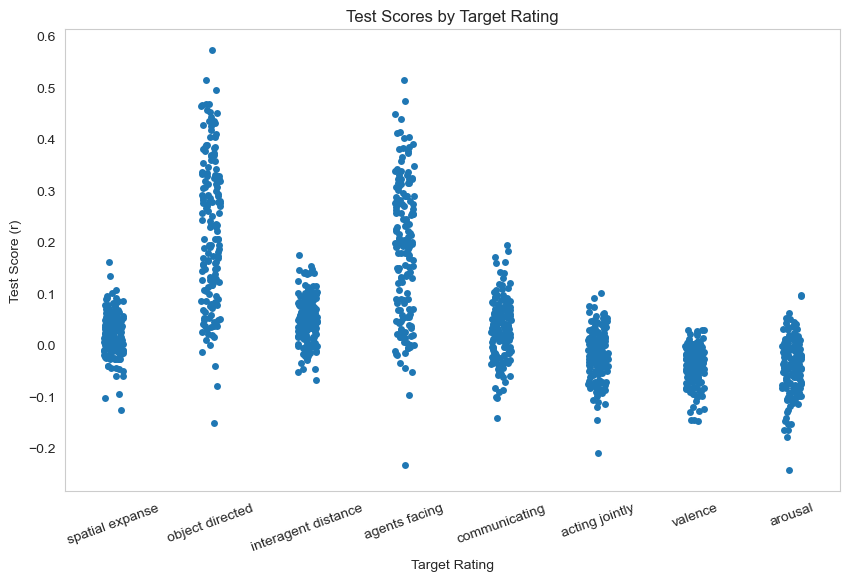

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

x_labels = ['spatial expanse', 'object directed', 'interagent distance', 'agents facing', 'communicating', 'acting jointly', 'valence', 'arousal']
# Assuming 'results_df' is the DataFrame returned by ridge_regression_benchmarking function
def plot_ridge_regression_results(results_df):
    plt.figure(figsize=(10, 6))
    
    
    # Plot each target's test score as a scatter plot
    sns.stripplot(x='target', y='test_score', data=results_df, jitter=True, dodge=True)
    
    # Plot median bars
    # sns.pointplot(data = results_df, x="target", y="test_score", linestyles='none', estimator=np.median, color='red', markers='_', errorbar=None, dodge=0.4,markeredgewid)

    
    plt.title('Test Scores by Target Rating')
    plt.xlabel('Target Rating')
    plt.ylabel('Test Score (r)')
    plt.xticks(ticks=range(len(x_labels)), labels=x_labels, rotation = 20)
    plt.grid(False)
    plt.show()

plot_ridge_regression_results(results)
